# Auto ML

In [1]:
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor
import utils.eda_utils as eda_utils 
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_error, r2_score
import numpy as np

d:\rockhead_prediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Load

## columns info

|column name|Description|test input|
|---|---|---|
|borehole_code|시추공 코드|X|
|x|위도|O|
|y|경도|O|
|depth_start|rockhead 시작 심도|output|
|Ground name|지반명- 0: 풍화암, 1: 연암, 2: 보통암, 4: 경암|O|
|Slope|경사|O|
|Aspect|경사방향|O|
|DEM|DEM|O|
|Rock Type|지질도에 따른 rock type|O|
|dis_bin|radius count에 따라 총 구간을 30개로 나눈 group|X|

* Rock type: {0:화성암, 1:퇴적암, 2:변성암}
* dis_bin: radius count 그룹에 따라 evaluation 하기 위한 값

In [2]:
train_df = pd.read_csv('data/241026_Rockhead_Seoul_train(before_aumentation).csv')
test_df = pd.read_csv('data/241026_Rockhead_Seoul_test(before_aumentation).csv')

C:\Users\user\AppData\Local\Temp\ipykernel_64836\2731312767.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_concat = pd.concat([df_concat, train_df_copy, test_df_copy])


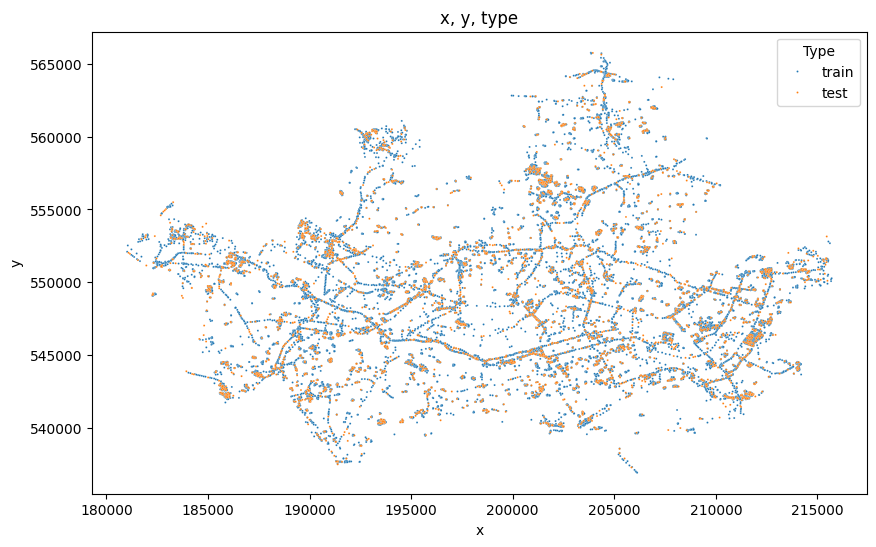

In [3]:
train_df_copy = train_df.copy()
test_df_copy = test_df.copy()


train_df_copy['Type'] = 'train'
test_df_copy['Type'] = 'test'

df_concat = pd.DataFrame(columns=train_df_copy.columns)
df_concat = pd.concat([df_concat, train_df_copy, test_df_copy])

eda_utils.scatter_relation(df_concat, 'x', 'y', 2, 'x, y, type','Type')

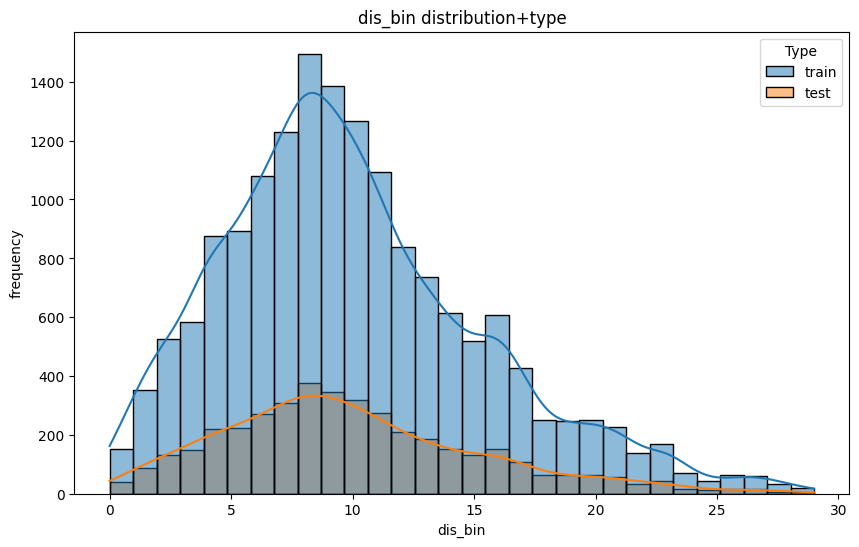

In [4]:
eda_utils.distribution_histogram(df_concat, 'dis_bin', 'dis_bin distribution+type', 'Type')

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16245 entries, 0 to 16244
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   x            16245 non-null  float64
 1   y            16245 non-null  float64
 2   depth_start  16245 non-null  float64
 3   slope        16245 non-null  float64
 4   aspect       16245 non-null  float64
 5   DEM          16245 non-null  float64
 6   rock_type_1  16245 non-null  bool   
 7   rock_type_2  16245 non-null  bool   
 8   dis_bin      16245 non-null  float64
dtypes: bool(2), float64(7)
memory usage: 920.3 KB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4061 entries, 0 to 4060
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   x            4061 non-null   float64
 1   y            4061 non-null   float64
 2   depth_start  4061 non-null   float64
 3   slope        4061 non-null   float64
 4   aspect       4061 non-null   float64
 5   DEM          4061 non-null   float64
 6   rock_type_1  4061 non-null   bool   
 7   rock_type_2  4061 non-null   bool   
 8   dis_bin      4061 non-null   float64
dtypes: bool(2), float64(7)
memory usage: 230.1 KB


## Training-Validation

In [7]:
train = TabularDataset(train_df.drop(['dis_bin'], axis=1))
test = TabularDataset(test_df.drop(['dis_bin'], axis=1))
X_test = TabularDataset(test_df.drop(['depth_start', 'dis_bin'], axis=1))
y_test = test_df['depth_start'].values.tolist()

In [8]:
predictor = TabularPredictor(label='depth_start', 
                             problem_type = 'regression', 
                             eval_metric='r2',
                             verbosity =2 
                             )

predictor.fit(train,
              num_gpus=1,
              time_limit = 3600*24, 
              presets="best_quality", 
              save_space = True, 
              keep_only_best = True,
              save_bag_folds = True,
              ag_args_fit = {'num_gpus': 1} # Train with GPU, # 140 models without gpu, 84 models with gpu during 3600*10(241026), 120 models with gpu during 3600*14(241028)
              )

No path specified. Models will be saved in: "AutogluonModels\ag-20241027_050358"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          16
Memory Avail:       18.60 GB / 31.93 GB (58.3%)
Disk Space Avail:   849.38 GB / 931.51 GB (91.2%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdo

In [9]:
ld_board = predictor.leaderboard(test, silent=True)

ld_board

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.772619,0.795908,r2,265.790257,260.221113,35335.604787,0.009501,0.000500,0.233541,3,True,120
1,NeuralNetTorch_r135_BAG_L2,0.772612,0.790167,r2,261.293306,253.239022,34173.964321,0.533094,0.161026,272.949414,2,True,118
2,NeuralNetTorch_r79_BAG_L2,0.772346,0.790071,r2,261.192288,253.237522,34118.814195,0.432076,0.159527,217.799288,2,True,112
3,NeuralNetTorch_r19_BAG_L2,0.771873,0.790066,r2,261.111273,253.223021,34064.578894,0.351061,0.145026,163.563987,2,True,119
4,NeuralNetFastAI_r145_BAG_L2,0.771093,0.791288,r2,261.729881,253.397049,34151.880625,0.969669,0.319053,250.865719,2,True,116
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,NeuralNetFastAI_r88_BAG_L1,0.533026,0.530822,r2,3.265319,0.064012,73.856398,3.265319,0.064012,73.856398,1,True,66
116,NeuralNetFastAI_r143_BAG_L1,0.529421,0.533759,r2,3.488422,0.068507,75.487109,3.488422,0.068507,75.487109,1,True,39
117,NeuralNetFastAI_r111_BAG_L1,0.524159,0.517770,r2,3.620565,0.054511,51.754780,3.620565,0.054511,51.754780,1,True,62
118,NeuralNetFastAI_r4_BAG_L1,0.510870,0.509102,r2,3.645401,0.149024,137.084082,3.645401,0.149024,137.084082,1,True,96


## Prediction

In [10]:
pred_y = predictor.predict(X_test, ld_board.model[1])

In [11]:
mae = mean_absolute_error(y_test, pred_y)
mse = mean_squared_error(y_test, pred_y)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred_y)

print('mae: ',mae)
print('mse: ',mse)
print('rmse: ',rmse)
print('r2: ',r2) #1에 가까울수록 좋음

mae:  2.323024653690961
mse:  11.511656862831723
rmse:  3.392883266903199
r2:  0.7726120421643478
